# 0. Import
***

In [242]:
import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-darkgrid')
sns.set_style("darkgrid")

# 1. Read data
***

In [379]:
data = pd.read_csv('data/train.csv', index_col='PassengerId')

In [380]:
data.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

# 2. Plot some graphs
***

In [284]:
data['Died'] = 1 - data['Survived']

<Figure size 1152x720 with 0 Axes>

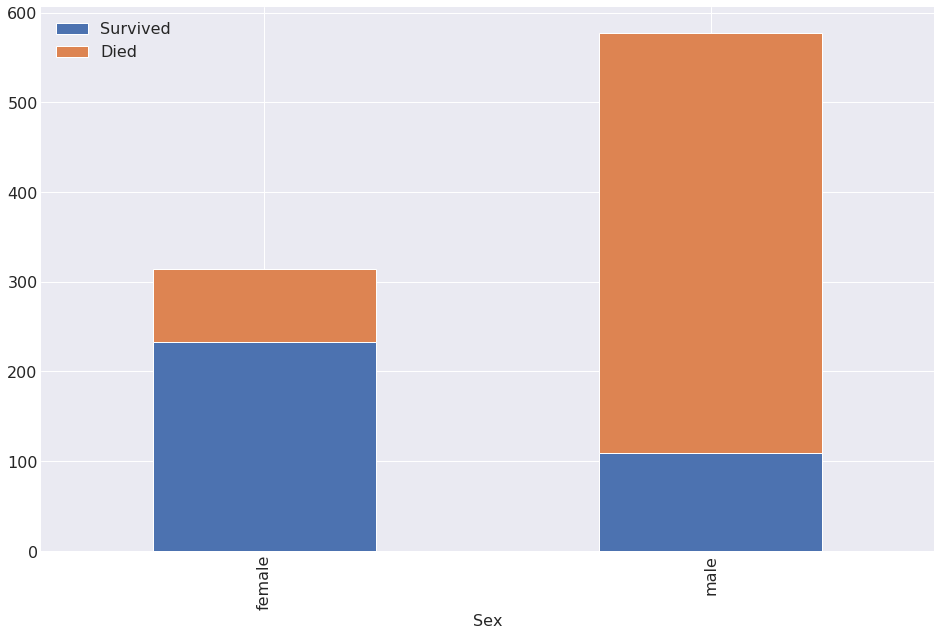

In [148]:
plt.figure(figsize=(16, 10))
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked=True)

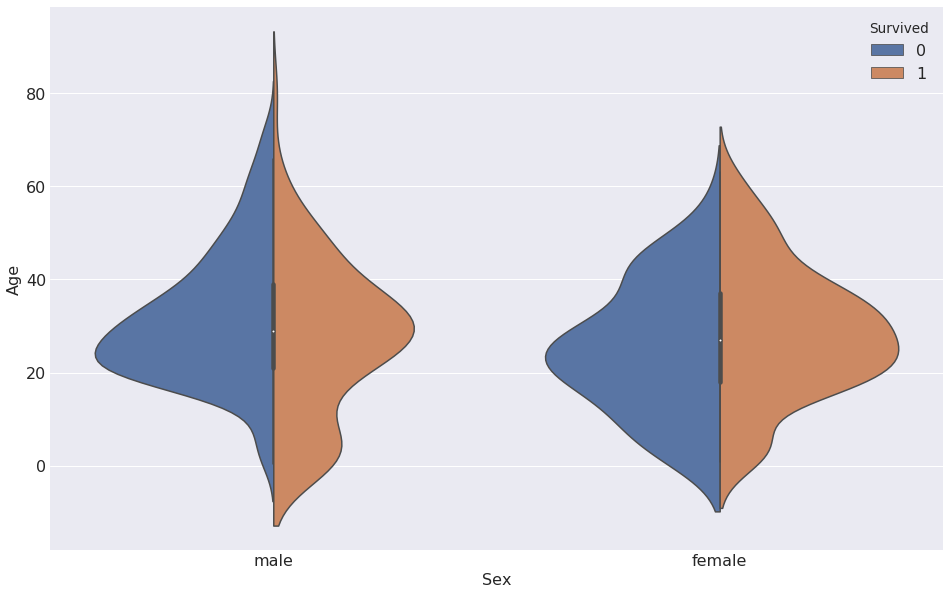

In [155]:
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True)
plt.show()

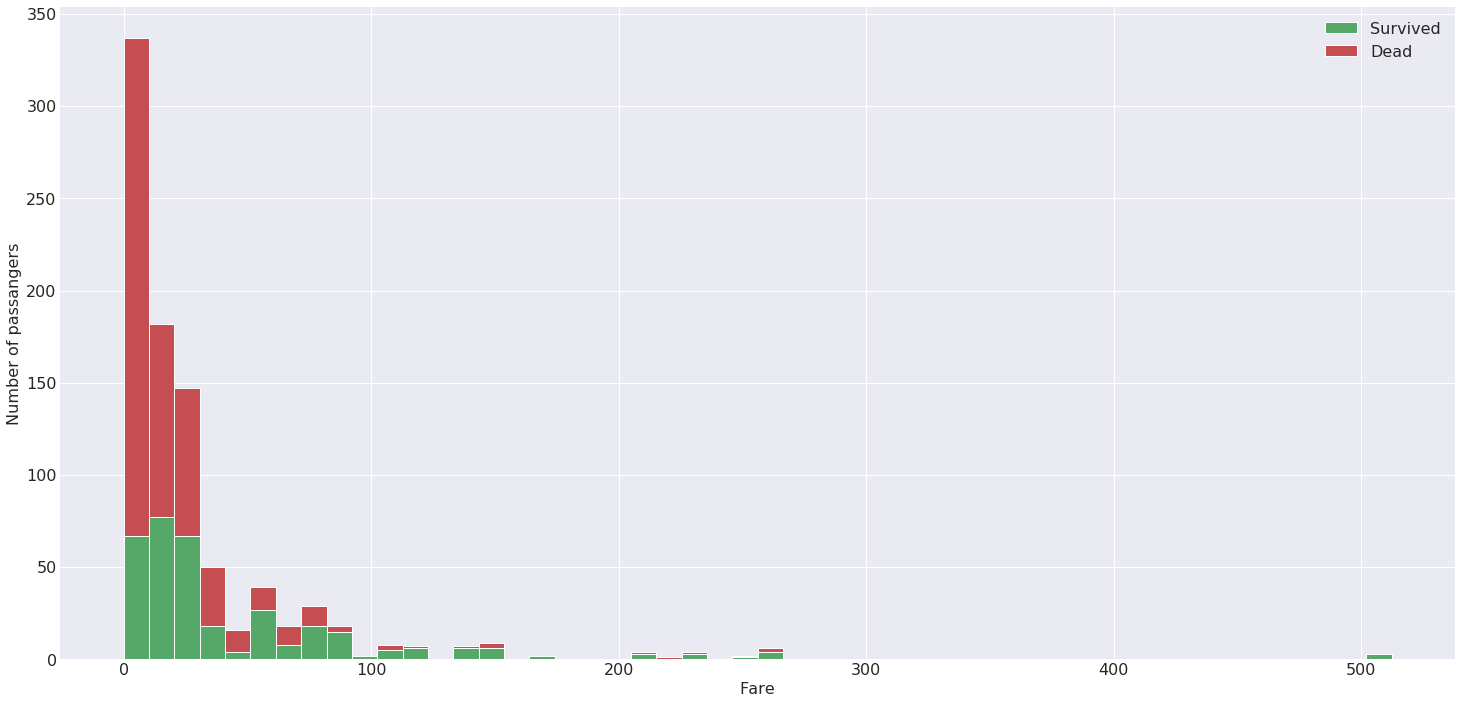

In [158]:
plt.figure(figsize=(25, 12))
plt.hist([data[data['Survived']==1]['Fare'], data[data['Survived']==0]['Fare']], stacked=True,
         color=['g', 'r'], bins=50, label=['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passangers')
plt.legend()
plt.show()

# 3. Preprocess data
***

In [381]:
data = data.drop('Cabin', axis=1)

In [382]:
def process_family_size(data=data):
    # Family size including passenger
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
    
    # Create another features that depends on family size
    data['Alone'] = data['FamilySize'].map(lambda x: 1 if x == 1 else 0)
    data['Small'] = data['FamilySize'].map(lambda x: 1 if 1 < x < 4 else 0)
    data['Large'] = data['FamilySize'].map(lambda x: 1 if x > 3 else 0)
    
    return data

data = process_family_size()

In [383]:
def process_embarked(data=data):
    # Fill missing embarked values with most frequent
    data['Embarked'] = data['Embarked'].fillna('S')
    
    data_dummy = pd.get_dummies(data['Embarked'], prefix='Embarked')
    data = pd.concat([data, data_dummy], axis=1)
    data = data.drop('Embarked', axis=1)
    
    return data
    
data = process_embarked()

In [384]:
X_train, y_train = data.drop('Survived', axis=1), data[['Survived']]
X_test = pd.read_csv('./data/test.csv', index_col='PassengerId')

In [385]:
X_test = X_test.drop('Cabin', axis=1)
X_test['Fare'] = X_test.fillna(X_test['Fare'].median())
X_test = process_family_size(data=X_test)
X_test = process_embarked(data=X_test)

In [386]:
def process_sex(data):
    data['Sex'] = data['Sex'].map(lambda x: 1 if x == 'male' else 0)
    return data

In [387]:
X_train = process_sex(data=X_train)
X_test = process_sex(data=X_test)

In [388]:
Title_Dictionary = {
    'Capt': 'Officer',
    'Col': 'Officer',
    'Don': 'Officer',
    'Dr': 'Officer',
    'Jonkheer': 'Royalty',
    'Lady': 'Royalty',
    'Major': 'Officer',
    'Master': 'Master',
    'Miss': 'Royalty',
    'Mlle': 'Miss',
    'Mme': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Ms': 'Mrs',
    'Rev': 'Officer',
    'Sir': 'Royalty', 
    'the Countess': 'Royalty',
    'Dona': 'Royalty'
}

In [389]:
def get_titles(data):
    # Get title by name
    data['Title'] = data['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    data['Title'] = data['Title'].map(Title_Dictionary)

    return data

X_train = get_titles(data=X_train)
X_test = get_titles(data=X_test)

In [390]:
grouped_train = X_train.groupby(['Sex', 'Pclass', 'Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [391]:
grouped_median_train.head()

Sex  Pclass    Title   Age
0    0       1     Miss  24.0
1    0       1      Mrs  40.0
2    0       1  Officer  49.0
3    0       1  Royalty  30.0
4    0       2      Mrs  31.5

In [392]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) &
        (grouped_median_train['Title'] == row['Title']) &
        (grouped_median_train['Pclass'] == row['Pclass'])
    )
    
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        condition = (
            (grouped_median_train['Pclass'] == row['Pclass']) &
            (grouped_median_train['Sex'] == row['Sex'])
        )
        
    return grouped_median_train[condition]['Age'].values[0]

def process_age(data):
    data['Age'] = data.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)    
    return data

X_train = process_age(data=X_train)
X_test = process_age(data=X_test)

In [393]:
def process_name(data):
    data = data.drop('Name', axis=1)
    data_dummies = pd.get_dummies(data['Title'], prefix='Title')
    
    data = pd.concat([data, data_dummies], axis=1)
    data = data.drop('Title', axis=1)
    
    return data

X_train = process_name(data=X_train)
X_test = process_name(data=X_test)

In [395]:
X_train = X_train.drop('Ticket', axis=1)
X_test = X_test.drop('Ticket', axis=1)

In [405]:
X_test['Title_Miss'] = 0

In [406]:
X_test

Pclass  Sex   Age  SibSp  Parch Fare  FamilySize  Alone  Small  \
PassengerId                                                                   
892               3    1  34.5      0      0    3           1      1      0   
893               3    0  47.0      1      0    3           2      0      1   
894               2    1  62.0      0      0    2           1      1      0   
895               3    1  27.0      0      0    3           1      1      0   
896               3    0  22.0      1      1    3           3      0      1   
897               3    1  14.0      0      0    3           1      1      0   
898               3    0  30.0      0      0    3           1      1      0   
899               2    1  26.0      1      1    2           3      0      1   
900               3    0  18.0      0      0    3           1      1      0   
901               3    1  21.0      2      0    3           3      0      1   
902               3    1  26.0      0      0    3           1      1      0   
903               1    1  46.0      0      0    1           1      1      0   
904               1    0  23.0      1      0    1           2      0      1   
905               2    1  63.0      1      0    2           2      0      1   
906               1    0  47.0      1      0    1           2      0      1   
907               2    0  24.0      1      0    2           2      0      1   
908               2    1  35.0      0      0    2           1      1      0   
909               3    1  21.0      0      0    3           1      1      0   
910               3    0  27.0      1      0    3           2      0      1   
911               3    0  45.0      0      0    3           1      1      0   
912               1    1  55.0      1      0    1           2      0      1   
913               3    1   9.0      0      1    3           2      0      1   
914               1    0  40.0      0      0    1           1      1      0   
915               1    1  21.0      0      1    1           2      0      1   
916               1    0  48.0      1      3    1           5      0      0   
917               3    1  50.0      1      0    3           2      0      1   
918               1    0  22.0      0      1    1           2      0      1   
919               3    1  22.5      0      0    3           1      1      0   
920               1    1  41.0      0      0    1           1      1      0   
921               3    1  26.0      2      0    3           3      0      1   
...             ...  ...   ...    ...    ...  ...         ...    ...    ...   
1280              3    1  21.0      0      0    3           1      1      0   
1281              3    1   6.0      3      1    3           5      0      0   
1282              1    1  23.0      0      0    1           1      1      0   
1283              1    0  51.0      0      1    1           2      0      1   
1284              3    1  13.0      0      2    3           3      0      1   
1285              2    1  47.0      0      0    2           1      1      0   
1286              3    1  29.0      3      1    3           5      0      0   
1287              1    0  18.0      1      0    1           2      0      1   
1288              3    1  24.0      0      0    3           1      1      0   
1289              1    0  48.0      1      1    1           3      0      1   
1290              3    1  22.0      0      0    3           1      1      0   
1291              3    1  31.0      0      0    3           1      1      0   
1292              1    0  30.0      0      0    1           1      1      0   
1293              2    1  38.0      1      0    2           2      0      1   
1294              1    0  22.0      0      1    1           2      0      1   
1295              1    1  17.0      0      0    1           1      1      0   
1296              1    1  43.0      1      0    1           2      0      1   
1297              2    1  20.0      0      0    2           1  

# 4. Fit model
***

In [399]:
%%time
n_estimators = [i for i in range(80, 201, 20)]
gb_params = {'n_estimators': n_estimators}
cv = KFold(n_splits=5, shuffle=True)
gb = GradientBoostingClassifier()

grid_searcher = GridSearchCV(estimator=gb, param_grid=gb_params, cv=cv)
grid_searcher.fit(X_train, y_train['Survived'].ravel())

CPU times: user 3.96 s, sys: 0 ns, total: 3.96 s
Wall time: 3.96 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=No

In [407]:
predict = grid_searcher.best_estimator_.predict(X_test)

In [408]:
grid_searcher.best_score_

0.8361391694725028

In [ ]:
%%time
rf_params = {'n_estimators': [i for i in range(60, 201, 20)],
             'min_samples_leaf': [2, 3, 4],
             'max_features': [0.3, 0.5, 0.7]
            }
clf = RandomForestClassifier(n_jobs=-1)
grid_searcher = GridSearchCV(param_grid=rf_params, estimator=clf, cv=cv)
grid_searcher.fit(X_train, y_train['Survived'].ravel())

In [241]:
grid_searcher.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

# Create submission file

In [409]:
submission = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission['PassengerId'], submission['Survived'] = X_test.index, predict

submission.to_csv('./submissions/submission_gb_3.csv', index=False)

In [410]:
check = pd.read_csv('./submissions/submission_gb_3.csv')
check.shape

(418, 2)

In [248]:
submission = pd.read_csv('./data/gender_submission.csv')
submission.shape

(418, 2)